In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import graspologic as gl
import pickle
import pandas as pd

In [6]:
with open('data/pruned_graph.gpickle', 'rb') as f:
    G = pickle.load(f)

In [9]:
sensory_neurons = [node for node in G.nodes if G.nodes[node]['neuron type'] == 'Sens.']
interneurons = [node for node in G.nodes if G.nodes[node]['neuron type'] == 'Inter.']
motor_neurons = [node for node in G.nodes if G.nodes[node]['neuron type'] == 'Mot.']
print(len(sensory_neurons))
print(len(interneurons))
print(len(motor_neurons))

53
32
32


In [14]:
# pass 1: filter to only sensory neurons that have a direct struc connection to interneuron
filt1_sens = {}
filt1_int = set()
for sn in sensory_neurons:
    for itn in interneurons:
        if G.has_edge(sn, itn) and G[sn][itn]['has_stx']:
            if sn not in filt1_sens:
                filt1_sens[sn] = []
            filt1_sens[sn].append(itn)
            filt1_int.add(itn)

# pass 2: filter interneurons to only those that have a direct struc connection to motor neuron and filter sensory neurons to only those that
# have struc connection to a filter interneuron
filt2_int = set()
filt_motor_neurons = set()
for itn in filt1_int:
    for mn in motor_neurons:
        if G.has_edge(itn, mn) and G[itn][mn]['has_stx']:
            filt_motor_neurons.add(mn)
            filt2_int.add(itn)
    if itn not in filt2_int:
        for sn in filt1_sens:
            if itn in filt1_sens[sn]:
                filt1_sens[sn].remove(itn)
filt_sens_neurons = {sn for sn in filt1_sens if len(filt1_sens[sn]) > 0}
filt_interneurons = filt2_int

print(len(filt_sens_neurons))
print(len(filt_interneurons))
print(len(filt_motor_neurons))

48
17
21


In [16]:
# checks

def check_motor_filt(motor_neurons, interneurons):
    for mn in motor_neurons:
        if not any(G.has_edge(itn, mn) for itn in interneurons):
            print(f"Motor neuron {mn} has no connection to any filtered interneurons.")
            return False
    return True

def check_inter_filt(interneurons, sensory_neurons):
    for itn in interneurons:
        if not any(G.has_edge(sn, itn) for sn in sensory_neurons):
            print(f"Interneuron {itn} has no connection to any filtered sensory neurons.")
            return False
        if not any(G.has_edge(itn, mn) for mn in motor_neurons):
            print(f"Interneuron {itn} has no connection to any filtered motor neurons.")
            return False
    return True

def check_sens_filt(sensory_neurons, interneurons):
    for sn in sensory_neurons:
        if not any(G.has_edge(sn, itn) for itn in interneurons):
            print(f"Sensor neuron {sn} has no connection to any filtered interneurons.")
            return False
    return True

print(check_motor_filt(filt_motor_neurons, filt_interneurons))
print(check_inter_filt(filt_interneurons, filt_sens_neurons))
print(check_sens_filt(filt_sens_neurons, filt_interneurons))
    

True
True
True


In [107]:
# for each sensory neurons, get most similar sensory neuron in terms of functional output (metric: bits different)

def get_func_output(ingoing, possible_outgoing, G):
    """get functional output vector as a binary list of connections to a set of outgoing neurons"""
    func_output = []
    for outgoing in possible_outgoing:
        if G.has_edge(ingoing, outgoing) and G[ingoing][outgoing]['fx_weight'] > 0:
            func_output.append(1)
        else:
            func_output.append(0)
    return np.array(func_output)

def get_struc_output(ingoing, possible_outgoing, G):
    """get structural output vector as a binary list of connections to a set of outgoing neurons"""
    func_output = []
    for outgoing in possible_outgoing:
        if G.has_edge(ingoing, outgoing) and G[ingoing][outgoing]['stx_weight'] > 0:
            func_output.append(1)
        else:
            func_output.append(0)
    return np.array(func_output)

def output_distance(v1, v2):
    return np.sum(v1 != v2)

# sens_func_outputs = {sn: get_func_output(sn, interneurons, G) for sn in filt_sens_neurons}
sens_func_outputs = {sn: get_struc_output(sn, interneurons, G) for sn in filt_sens_neurons}
sens_to_min_dist_sens = {}
for sn in filt_sens_neurons:
    without_self_outputs = {key: value for key, value in sens_func_outputs.items() if key != sn}
    min_dist_sens = min(without_self_outputs, key=lambda x: output_distance(sens_func_outputs[sn], without_self_outputs[x]))
    min_dist = output_distance(sens_func_outputs[sn], without_self_outputs[min_dist_sens])
    sens_to_min_dist_sens[sn] = (min_dist_sens, min_dist)

# convert sens_to_min_dist_sens to a pandas df
closest_sens_df = pd.DataFrame(columns=['neuron_name', 'closest_neuron', 'dist'])
for sn, infos in sens_to_min_dist_sens.items():
    neuron_name, closest_neuron, dist = sn, infos[0], infos[1]
    closest_sens_df.loc[len(closest_sens_df)] = {'neuron_name': neuron_name, 'closest_neuron': closest_neuron, 'dist': dist} 

closest_sens_df

,neuron_name,closest_neuron,dist
0,ASHL,ADLL,3
1,BAGR,AUAL,5
2,URXR,BAGL,4
3,ASGL,ASIL,2
4,FLPR,URYVR,4
5,IL2DR,OLQVR,0
6,URYVR,FLPR,4
7,SAADR,SAAVR,2
8,SAAVR,SAADR,2
9,ADLR,ASGR,5


In [130]:
# candidate neurons with identical 
s1 = 'SAAVR'
s2 = 'SAADR'
def get_feedforward_subgrapg(s1, s2):
    g = nx.DiGraph()
    for sn in [s1, s2]:
        g.add_node(sn, neuron_type='Sens.')
        for itn in filt_interneurons:
            if G.has_edge(sn, itn) and G[sn][itn]['has_stx']:
                g.add_node(itn, neuron_type='Inter.')
                g.add_edge(sn, itn, stx_weight = G[sn][itn]['stx_weight'])
    g_inter = [node for node in g.nodes if g.nodes[node]['neuron_type'] == 'Inter.']
    for mn in filt_motor_neurons:
        for itn in g_inter:
            if G.has_edge(itn, mn) and G[itn][mn]['has_stx']:
                g.add_node(mn, neuron_type='Mot.')
                g.add_edge(itn, mn, stx_weight = G[itn][mn]['stx_weight'])
    return g

g = get_feedforward_subgrapg(s1, s2)

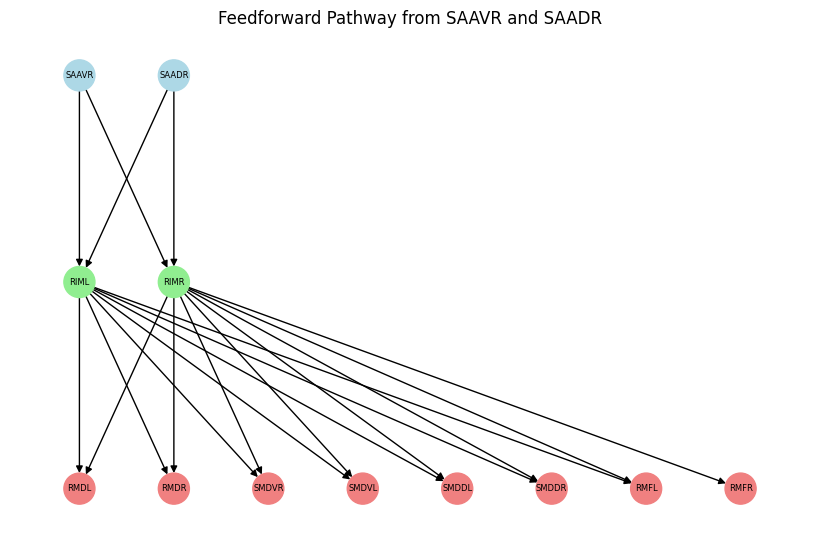

In [131]:
pos = {}
layer_gap = 1.5 

for i, node in enumerate([n for n in g.nodes if g.nodes[n]['neuron_type'] == 'Sens.']):
    pos[node] = (i, 2 * layer_gap)

for i, node in enumerate([n for n in g.nodes if g.nodes[n]['neuron_type'] == 'Inter.']):
    pos[node] = (i, layer_gap)

for i, node in enumerate([n for n in g.nodes if g.nodes[n]['neuron_type'] == 'Mot.']):
    pos[node] = (i, 0)

plt.figure(figsize=(8, 5)) 
nx.draw(
    g, pos, with_labels=True, node_size=500, font_size=6,
    node_color=[{'Sens.': 'lightblue', 'Inter.': 'lightgreen', 'Mot.': 'lightcoral'}[g.nodes[n]['neuron_type']] for n in g.nodes]
)
plt.title(f"Feedforward Pathway from {s1} and {s2}")
plt.show()

In [116]:
motor_neuron_from_sens_paths = {}
for mn in g.nodes():
    if g.nodes[mn]['neuron_type'] == 'Mot.':
        connected_sens = []
        if nx.has_path(g, s1, mn):
            connected_sens.append(s1)
        if nx.has_path(g, s2, mn):
            connected_sens.append(s2)
        motor_neuron_from_sens_paths[mn] = connected_sens

print(motor_neuron_from_sens_paths)

{'RMDL': ['SAAVR', 'SAADR'], 'RMDR': ['SAAVR', 'SAADR'], 'SMDVR': ['SAAVR', 'SAADR'], 'SMDVL': ['SAAVR', 'SAADR'], 'SMDDL': ['SAAVR', 'SAADR'], 'SMDDR': ['SAAVR', 'SAADR'], 'RMFL': ['SAAVR', 'SAADR'], 'RMFR': ['SAAVR', 'SAADR']}


In [117]:
s1_activations = []
s2_activations = []

for mn in motor_neuron_from_sens_paths:
    if G.has_edge(s1, mn) and G[s1][mn]['has_fx']:
        s1_activations.append(mn)
    if G.has_edge(s2, mn) and G[s2][mn]['has_fx']:
        s2_activations.append(mn)

print("S1:", s1_activations)
print("S2:", s2_activations)
itn_activations = {}
for itn in g.nodes:
    if g.nodes[itn]['neuron_type'] == 'Inter.':
        if G.has_edge(s1, itn) and G[s1][itn]['has_fx']:
            s1_activations.append(itn)
        if G.has_edge(s2, itn) and G[s2][itn]['has_fx']:
            s2_activations.append(itn)
        if itn not in itn_activations:
            itn_activations[itn] = []
        for mn in motor_neuron_from_sens_paths:
            if G.has_edge(itn, mn) and G[itn][mn]['has_fx']:
                itn_activations[itn].append(mn)
itn_activations

S1: ['RMDR', 'SMDVL']
S2: ['SMDDL', 'SMDDR', 'RMFL']


{'RIML': ['SMDDL', 'RMFR'], 'RIMR': ['RMDR', 'RMFR']}

In [118]:
# put everything into pandas df

motor_s1s2_df = pd.DataFrame(columns=['neuron_name', 'path_from_s1', 'path_from_s2', 's1_fx', 's2_fx'])
for mn in motor_neuron_from_sens_paths:
    path_from_s1 = s1 in motor_neuron_from_sens_paths[mn]
    path_from_s2 = s2 in motor_neuron_from_sens_paths[mn]
    s1_fx = mn in s1_activations
    s2_fx = mn in s2_activations
    motor_s1s2_df.loc[len(motor_s1s2_df)] = {'neuron_name': mn, 'path_from_s1': path_from_s1, 'path_from_s2': path_from_s2, 's1_fx': s1_fx, 's2_fx': s2_fx}
    
motor_s1s2_df

,neuron_name,path_from_s1,path_from_s2,s1_fx,s2_fx
0,RMDL,True,True,False,False
1,RMDR,True,True,True,False
2,SMDVR,True,True,False,False
3,SMDVL,True,True,True,False
4,SMDDL,True,True,False,True
5,SMDDR,True,True,False,True
6,RMFL,True,True,False,True
7,RMFR,True,True,False,False


In [119]:
# compute 2-connection column
motor_s1s2_df['2-path'] = (motor_s1s2_df['path_from_s1']) & (motor_s1s2_df['path_from_s2'])
motor_s1s2_df['2-fx'] = (motor_s1s2_df['s1_fx']) & (motor_s1s2_df['s2_fx'])
motor_s1s2_df

,neuron_name,path_from_s1,path_from_s2,s1_fx,s2_fx,2-path,2-fx
0,RMDL,True,True,False,False,True,False
1,RMDR,True,True,True,False,True,False
2,SMDVR,True,True,False,False,True,False
3,SMDVL,True,True,True,False,True,False
4,SMDDL,True,True,False,True,True,False
5,SMDDR,True,True,False,True,True,False
6,RMFL,True,True,False,True,True,False
7,RMFR,True,True,False,False,True,False


In [120]:
correlation_matrix = motor_s1s2_df.drop(columns=['neuron_name']).corr(method='spearman')
print(correlation_matrix)

              path_from_s1  path_from_s2     s1_fx     s2_fx  2-path  2-fx
path_from_s1           NaN           NaN       NaN       NaN     NaN   NaN
path_from_s2           NaN           NaN       NaN       NaN     NaN   NaN
s1_fx                  NaN           NaN  1.000000 -0.447214     NaN   NaN
s2_fx                  NaN           NaN -0.447214  1.000000     NaN   NaN
2-path                 NaN           NaN       NaN       NaN     NaN   NaN
2-fx                   NaN           NaN       NaN       NaN     NaN   NaN


In [129]:
# for each pair of sensory neurons, get a vector of interneuron and gates

def get_interneuron_and_vec(s1, s2):
    base = [0] * len(filt_interneurons)
    for ix, itn in enumerate(filt_interneurons):
        if not G.has_edge(s1, itn) or not G.has_edge(s2, itn):
            continue
        if not G[s1][itn]['has_stx'] or not G[s2][itn]['has_stx']:
            continue
        base[ix] = True
    return np.array(base)

and_itn_vecs = np.ndarray(shape=(len(filt_sens_neurons), len(filt_sens_neurons), len(filt_interneurons)), dtype=bool)
for i, s1 in enumerate(filt_sens_neurons):
    for j, s2 in enumerate(filt_sens_neurons):
        if i == j:
            continue
        and_itn_vecs[i][j] = get_interneuron_and_vec(s1, s2)
        and_itn_vecs[j][i] = and_itn_vecs[i][j]

In [133]:
# project and gate vectors down onto motor neurons
def get_itn_to_mot_projection(itn_vec):
    mot_vec = np.zeros(len(filt_motor_neurons), dtype=bool)
    for ix, itn in enumerate(filt_interneurons):
        if itn_vec[ix]: # if active in itn_vec
            for ixm, mn in enumerate(filt_motor_neurons):
                if G.has_edge(itn, mn) and G[itn][mn]['has_stx']:
                    mot_vec[ixm] = True
    return mot_vec

motor_proj = np.ndarray(shape=(len(filt_sens_neurons), len(filt_sens_neurons), len(filt_motor_neurons)), dtype=bool)
for i, s1 in enumerate(filt_sens_neurons):
    for j, s2 in enumerate(filt_sens_neurons):
        if i == j:
            continue
        motor_proj[i][j] = get_itn_to_mot_projection(and_itn_vecs[i][j])
        motor_proj[j][i] = motor_proj[i][j]

In [145]:
# build data frame consisting of motor neuron activations for each pair of sensory neurons

motor_activation_df = pd.DataFrame(columns=['sensory_neuron_1', 'sensory_neuron_2', 'motor_activation', 'motor_projection'])

for i, s1 in enumerate(filt_sens_neurons):
    for j, s2 in enumerate(filt_sens_neurons):
        if i == j:
            continue
        # skip if opposite order already in motor_activation_df
        if not motor_activation_df[
            (motor_activation_df['sensory_neuron_1'] == s2) & 
            (motor_activation_df['sensory_neuron_2'] == s1)
        ].empty:
            continue
        mn_act_vec = np.zeros(len(filt_motor_neurons), dtype=bool)
        for ixm, mn in enumerate(filt_motor_neurons):
            # sens 1 active
            if G.has_edge(s1, mn) and G[s1][mn]['has_fx']:
                sens1_active = True
            else:
                sens1_active = False
            # sens 2 active
            if G.has_edge(s2, mn) and G[s2][mn]['has_fx']:
                sens2_active = True
            else:
                sens2_active = False
            mn_act_vec[ixm] = not (sens1_active or sens2_active)
            # add to df
        motor_activation_df.loc[len(motor_activation_df)] = {'sensory_neuron_1': s1, 'sensory_neuron_2': s2, 'motor_activation': mn_act_vec, 'motor_projection': motor_proj[i][j]}
            
motor_activation_df

,sensory_neuron_1,sensory_neuron_2,motor_activation,motor_projection
0,ASHL,BAGR,"[True, True, True, True, True, True, True, Fal...","[True, True, False, True, False, True, False, ..."
1,ASHL,URXR,"[True, True, True, True, True, True, True, Fal...","[False, False, False, False, False, False, Fal..."
2,ASHL,ASGL,"[True, True, True, True, True, True, True, Fal...","[False, True, True, True, True, False, False, ..."
3,ASHL,FLPR,"[True, True, True, True, True, True, True, Fal...","[False, False, False, False, False, False, Fal..."
4,ASHL,IL2DR,"[True, True, True, True, True, True, True, Fal...","[False, False, False, False, False, False, Fal..."
...,...,...,...,...
1123,ASIR,URBR,"[True, True, True, True, False, True, True, Tr...","[False, False, False, False, False, False, Fal..."
1124,ASIR,URXL,"[True, True, True, True, False, True, True, Fa...","[False, False, False, False, False, False, Fal..."
1125,BAGL,URBR,"[True, True, True, True, True, False, True, Tr...","[False, False, False, False, False, False, Fal..."
1126,BAGL,URXL,"[True, True, True, True, True, False, True, Fa...","[False, False, False, False, False, False, Fal..."


In [153]:
import numpy as np

A = np.stack(motor_activation_df["motor_activation"].values)
P = np.stack(motor_activation_df["motor_projection"].values)

r_global = np.corrcoef(A.ravel().astype(int),
                       P.ravel().astype(int))[0, 1]
print("overall Pearson r:", r_global)

overall Pearson r: -0.04545592320491755
